<a href="https://colab.research.google.com/github/joyangelai/FPL_Optimizer/blob/main/FPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FANTASY PREMIER LEAGUE OPTIMIZER

This is an application intended to:

*   Fetch and clean weekly FPL data (players, fixtures and stats)
*   Build models to predict expected points for each player.
*   Optimize squad selection under FPL constraints.
*   Display Best XI, captain, vice captain and expected points in a user friendly way



This notebook is for prototyping then we will migrate to GitHub to set up deployment pipelines.

# Importation & loading datasets



In [123]:
# import necessary libraries
import pandas as pd
import numpy as np
import requests
import pulp

In [124]:
# fetching the dataset
url = "https://fantasy.premierleague.com/api/bootstrap-static/"
data = requests.get(url).json()
players = pd.DataFrame(data['elements'])
teams = pd.DataFrame(data['teams'])
fixtures = pd.DataFrame(data['events'])


In [125]:
# display data
players.head()


,can_transact,can_select,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,...,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,defensive_contribution_per_90
0,True,True,NaN,NaN,154561,1,-1,5,-5,1,...,1,116,8,56,4,6,1,1.0,0.53,0.00
1,True,True,NaN,NaN,109745,-1,1,-4,4,0,...,38,493,72,569,78,265,34,0.0,0.00,0.00
2,True,False,0.0,0.0,463748,0,0,0,0,0,...,54,460,62,537,68,339,48,0.0,0.00,0.00
3,True,True,NaN,NaN,551221,0,0,-1,1,0,...,86,427,45,505,51,357,51,0.0,0.00,0.00
4,True,True,0.0,0.0,226597,-1,1,2,-2,3,...,3,740,248,2,1,24,8,1.0,0.64,9.09


In [126]:
teams.head()


,code,draw,form,id,loss,name,played,points,position,short_name,...,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,None,1,0,Arsenal,0,0,1,ARS,...,None,False,0,1300,1375,1340,1400,1260,1350,1
1,7,0,None,2,0,Aston Villa,0,0,3,AVL,...,None,False,0,1145,1185,1150,1170,1140,1200,2
2,90,0,None,3,0,Burnley,0,0,19,BUR,...,None,False,0,1055,1095,1010,1090,1100,1100,43
3,91,0,None,4,0,Bournemouth,0,0,13,BOU,...,None,False,0,1150,1220,1100,1240,1200,1200,127
4,94,0,None,5,0,Brentford,0,0,14,BRE,...,None,False,0,1135,1175,1100,1110,1170,1240,130


In [127]:
fixtures.tail()

,id,name,deadline_time,release_time,average_entry_score,finished,data_checked,highest_scoring_entry,deadline_time_epoch,deadline_time_game_offset,...,ranked_count,overrides,chip_plays,most_selected,most_transferred_in,top_element,top_element_info,transfers_made,most_captained,most_vice_captained
33,34,Gameweek 34,2026-04-25T12:30:00Z,None,0,False,False,NaN,1777120200,0,...,0,"{'rules': {}, 'scoring': {}, 'element_types': ...",[],NaN,NaN,NaN,None,0,NaN,NaN
34,35,Gameweek 35,2026-05-02T12:30:00Z,None,0,False,False,NaN,1777725000,0,...,0,"{'rules': {}, 'scoring': {}, 'element_types': ...",[],NaN,NaN,NaN,None,0,NaN,NaN
35,36,Gameweek 36,2026-05-09T12:30:00Z,None,0,False,False,NaN,1778329800,0,...,0,"{'rules': {}, 'scoring': {}, 'element_types': ...",[],NaN,NaN,NaN,None,0,NaN,NaN
36,37,Gameweek 37,2026-05-17T12:30:00Z,None,0,False,False,NaN,1779021000,0,...,0,"{'rules': {}, 'scoring': {}, 'element_types': ...",[],NaN,NaN,NaN,None,0,NaN,NaN
37,38,Gameweek 38,2026-05-24T13:30:00Z,None,0,False,False,NaN,1779629400,0,...,0,"{'rules': {}, 'scoring': {}, 'element_types': ...",[],NaN,NaN,NaN,None,0,NaN,NaN


We are working with three datasets which are crucial in building our application.

# Data Cleaning

## Players dataset


In [128]:
# display data
players.head()

,can_transact,can_select,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,...,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,defensive_contribution_per_90
0,True,True,NaN,NaN,154561,1,-1,5,-5,1,...,1,116,8,56,4,6,1,1.0,0.53,0.00
1,True,True,NaN,NaN,109745,-1,1,-4,4,0,...,38,493,72,569,78,265,34,0.0,0.00,0.00
2,True,False,0.0,0.0,463748,0,0,0,0,0,...,54,460,62,537,68,339,48,0.0,0.00,0.00
3,True,True,NaN,NaN,551221,0,0,-1,1,0,...,86,427,45,505,51,357,51,0.0,0.00,0.00
4,True,True,0.0,0.0,226597,-1,1,2,-2,3,...,3,740,248,2,1,24,8,1.0,0.64,9.09


In [129]:
# dataset size
players.shape

(759, 102)

In [130]:
# checking the data info
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Columns: 102 entries, can_transact to defensive_contribution_per_90
dtypes: bool(6), float64(15), int64(51), object(30)
memory usage: 573.8+ KB


In [131]:
# checking columns
players.columns.tolist()

['can_transact',
 'can_select',
 'chance_of_playing_next_round',
 'chance_of_playing_this_round',
 'code',
 'cost_change_event',
 'cost_change_event_fall',
 'cost_change_start',
 'cost_change_start_fall',
 'dreamteam_count',
 'element_type',
 'ep_next',
 'ep_this',
 'event_points',
 'first_name',
 'form',
 'id',
 'in_dreamteam',
 'news',
 'news_added',
 'now_cost',
 'photo',
 'points_per_game',
 'removed',
 'second_name',
 'selected_by_percent',
 'special',
 'squad_number',
 'status',
 'team',
 'team_code',
 'total_points',
 'transfers_in',
 'transfers_in_event',
 'transfers_out',
 'transfers_out_event',
 'value_form',
 'value_season',
 'web_name',
 'region',
 'team_join_date',
 'birth_date',
 'has_temporary_code',
 'opta_code',
 'minutes',
 'goals_scored',
 'assists',
 'clean_sheets',
 'goals_conceded',
 'own_goals',
 'penalties_saved',
 'penalties_missed',
 'yellow_cards',
 'red_cards',
 'saves',
 'bonus',
 'bps',
 'influence',
 'creativity',
 'threat',
 'ict_index',
 'clearances_blo

We do have a big dataset. We cannot work with 102 columns as this will overwhelm our model.

In [132]:
# new player data
useful_cols = [
    'id','first_name','second_name','web_name','team','element_type',
    'now_cost','status','chance_of_playing_this_round','chance_of_playing_next_round',
    'minutes','goals_scored','assists','clean_sheets','saves','bonus',
    'total_points','points_per_game','form'
]

# Create a reduced DataFrame
new_players = players[useful_cols].copy()


In [133]:
# new players dataset
new_players.head()

,id,first_name,second_name,web_name,team,element_type,now_cost,status,chance_of_playing_this_round,chance_of_playing_next_round,minutes,goals_scored,assists,clean_sheets,saves,bonus,total_points,points_per_game,form
0,1,David,Raya Martín,Raya,1,1,60,a,NaN,NaN,1350,0,0,8,25,3,66,4.4,3.2
1,2,Kepa,Arrizabalaga Revuelta,Arrizabalaga,1,1,41,a,NaN,NaN,0,0,0,0,0,0,0,0.0,0.0
2,3,Karl,Hein,Hein,1,1,40,u,0.0,0.0,0,0,0,0,0,0,0,0.0,0.0
3,4,Tommy,Setford,Setford,1,1,39,a,NaN,NaN,0,0,0,0,0,0,0,0.0,0.0
4,5,Gabriel,dos Santos Magalhães,Gabriel,1,2,62,i,0.0,0.0,990,1,2,7,0,13,81,7.4,0.0


In [134]:
new_players.shape

(759, 19)

In [135]:
new_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            759 non-null    int64  
 1   first_name                    759 non-null    object 
 2   second_name                   759 non-null    object 
 3   web_name                      759 non-null    object 
 4   team                          759 non-null    int64  
 5   element_type                  759 non-null    int64  
 6   now_cost                      759 non-null    int64  
 7   status                        759 non-null    object 
 8   chance_of_playing_this_round  449 non-null    float64
 9   chance_of_playing_next_round  456 non-null    float64
 10  minutes                       759 non-null    int64  
 11  goals_scored                  759 non-null    int64  
 12  assists                       759 non-null    int64  
 13  clean

In [136]:
# cleaning column names by renaming
new_players.rename(columns={'id':'player_id',
                            'element_type':'position_id',
                            'now_cost':'price'}, inplace=True)

new_players['price'] = new_players['price'] / 10.0  # we are converting this to the real fpl price in millions
new_players['name'] = new_players['first_name'] + " " + new_players['second_name']

In [137]:
new_players.head()

,player_id,first_name,second_name,web_name,team,position_id,price,status,chance_of_playing_this_round,chance_of_playing_next_round,minutes,goals_scored,assists,clean_sheets,saves,bonus,total_points,points_per_game,form,name
0,1,David,Raya Martín,Raya,1,1,6.0,a,NaN,NaN,1350,0,0,8,25,3,66,4.4,3.2,David Raya Martín
1,2,Kepa,Arrizabalaga Revuelta,Arrizabalaga,1,1,4.1,a,NaN,NaN,0,0,0,0,0,0,0,0.0,0.0,Kepa Arrizabalaga Revuelta
2,3,Karl,Hein,Hein,1,1,4.0,u,0.0,0.0,0,0,0,0,0,0,0,0.0,0.0,Karl Hein
3,4,Tommy,Setford,Setford,1,1,3.9,a,NaN,NaN,0,0,0,0,0,0,0,0.0,0.0,Tommy Setford
4,5,Gabriel,dos Santos Magalhães,Gabriel,1,2,6.2,i,0.0,0.0,990,1,2,7,0,13,81,7.4,0.0,Gabriel dos Santos Magalhães


In [138]:
# checking for unique values in columns
for column in new_players:
  unique_values = new_players[column].unique()
  print(f"Unique values in {column} \n: {unique_values}")

Unique values in player_id 
: [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  28  29  30  31 266 662 666 700 711 725 759
  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  53  54  55  56  57  58  59  60  61  62  63  64  65 389 456 677
 688 701 702 703 710 719 754 757 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 470 676 680 722  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 391 685 687 697 713 721 756
  27  83 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 136
 137 748 138 139 140 141 142 143 144 145 146 147 148 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 169 170 171 172 173
 174 175 176 177 178 

In [139]:
# Check missing values
new_players.isnull().sum()

,0
player_id,0
first_name,0
second_name,0
web_name,0
team,0
position_id,0
price,0
status,0
chance_of_playing_this_round,310
chance_of_playing_next_round,303


In [140]:
# checking duplicates
new_players.duplicated().sum()

np.int64(0)

In [141]:
# handling missing values
new_players['chance_of_playing_this_round'] = new_players['chance_of_playing_this_round'].fillna(100).astype(int)
new_players['chance_of_playing_next_round'] = new_players['chance_of_playing_next_round'].fillna(100).astype(int)


We are filing the chances with 100 as an assumption that the player is expected to play. Filling the values with 0 would unfairly exclude healthy players.

In [142]:
# verify missing values
new_players.isnull().sum()

,0
player_id,0
first_name,0
second_name,0
web_name,0
team,0
position_id,0
price,0
status,0
chance_of_playing_this_round,0
chance_of_playing_next_round,0


In [143]:
new_players.sample()

,player_id,first_name,second_name,web_name,team,position_id,price,status,chance_of_playing_this_round,chance_of_playing_next_round,minutes,goals_scored,assists,clean_sheets,saves,bonus,total_points,points_per_game,form,name
466,414,Phil,Foden,Foden,13,3,8.6,a,100,100,1045,6,2,6,0,9,77,5.9,11.5,Phil Foden


In [144]:
# drop unnecessary columns
new_players = new_players.drop(columns=['first_name','second_name','web_name'])
new_players.sample(3)

,player_id,team,position_id,price,status,chance_of_playing_this_round,chance_of_playing_next_round,minutes,goals_scored,assists,clean_sheets,saves,bonus,total_points,points_per_game,form,name
11,13,1,2,3.8,a,100,100,0,0,0,0,0,0,0,0.0,0.0,Brayden Clarke
57,54,2,3,5.4,a,100,100,1144,1,1,6,0,1,43,2.9,3.2,John McGinn
583,521,16,3,4.9,a,100,100,774,1,0,2,0,0,29,2.4,2.8,Ibrahim Sangaré


## Teams Dataset

In [145]:
# load dataset
teams.head()

,code,draw,form,id,loss,name,played,points,position,short_name,...,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,None,1,0,Arsenal,0,0,1,ARS,...,None,False,0,1300,1375,1340,1400,1260,1350,1
1,7,0,None,2,0,Aston Villa,0,0,3,AVL,...,None,False,0,1145,1185,1150,1170,1140,1200,2
2,90,0,None,3,0,Burnley,0,0,19,BUR,...,None,False,0,1055,1095,1010,1090,1100,1100,43
3,91,0,None,4,0,Bournemouth,0,0,13,BOU,...,None,False,0,1150,1220,1100,1240,1200,1200,127
4,94,0,None,5,0,Brentford,0,0,14,BRE,...,None,False,0,1135,1175,1100,1110,1170,1240,130


In [146]:
# dataset size
teams.shape

(20, 21)

In [147]:
# display data info
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   code                   20 non-null     int64 
 1   draw                   20 non-null     int64 
 2   form                   0 non-null      object
 3   id                     20 non-null     int64 
 4   loss                   20 non-null     int64 
 5   name                   20 non-null     object
 6   played                 20 non-null     int64 
 7   points                 20 non-null     int64 
 8   position               20 non-null     int64 
 9   short_name             20 non-null     object
 10  strength               20 non-null     int64 
 11  team_division          0 non-null      object
 12  unavailable            20 non-null     bool  
 13  win                    20 non-null     int64 
 14  strength_overall_home  20 non-null     int64 
 15  strength_overall_away  20

In [148]:
# extract useful columns for our dataset
useful = [
    'id','name','short_name','strength',
    'strength_overall_home','strength_overall_away',
    'strength_attack_home','strength_attack_away',
    'strength_defence_home','strength_defence_away'
]
new_teams = teams[useful].copy()


In [149]:
# rename id column for clarity
new_teams.rename(columns={'id':'team_id'},inplace=True)
new_teams.sample(4)

,team_id,name,short_name,strength,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away
7,8,Crystal Palace,CRY,3,1165,1205,1150,1150,1180,1260
9,10,Fulham,FUL,3,1090,1130,1080,1140,1100,1120
11,12,Liverpool,LIV,4,1230,1265,1170,1210,1290,1320
0,1,Arsenal,ARS,5,1300,1375,1340,1400,1260,1350


In [150]:
# checking for unique values in columns
for column in new_teams:
  unique_values = new_teams[column].unique()
  print(f"Unique values in {column} \n: {unique_values}")

Unique values in team_id 
: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Unique values in name 
: ['Arsenal' 'Aston Villa' 'Burnley' 'Bournemouth' 'Brentford' 'Brighton'
 'Chelsea' 'Crystal Palace' 'Everton' 'Fulham' 'Leeds' 'Liverpool'
 'Man City' 'Man Utd' 'Newcastle' "Nott'm Forest" 'Sunderland' 'Spurs'
 'West Ham' 'Wolves']
Unique values in short_name 
: ['ARS' 'AVL' 'BUR' 'BOU' 'BRE' 'BHA' 'CHE' 'CRY' 'EVE' 'FUL' 'LEE' 'LIV'
 'MCI' 'MUN' 'NEW' 'NFO' 'SUN' 'TOT' 'WHU' 'WOL']
Unique values in strength 
: [5 3 4]
Unique values in strength_overall_home 
: [1300 1145 1055 1150 1135 1180 1165 1100 1090 1095 1230 1250 1160 1075
 1070]
Unique values in strength_overall_away 
: [1375 1185 1095 1220 1175 1160 1190 1205 1130 1145 1265 1305 1075 1085]
Unique values in strength_attack_home 
: [1340 1150 1010 1100 1090 1140 1110 1080 1170 1210 1130 1050]
Unique values in strength_attack_away 
: [1400 1170 1090 1240 1110 1160 1150 1130 1140 1100 1210 1230 1180 1120
 1050]
Unique

In [151]:
# dataset size
new_teams.shape

(20, 10)

In [152]:
# check for missing values
new_teams.isnull().sum()

,0
team_id,0
name,0
short_name,0
strength,0
strength_overall_home,0
strength_overall_away,0
strength_attack_home,0
strength_attack_away,0
strength_defence_home,0
strength_defence_away,0


## Fixtures Dataset


In [153]:
# load dataset
fixtures.head()

,id,name,deadline_time,release_time,average_entry_score,finished,data_checked,highest_scoring_entry,deadline_time_epoch,deadline_time_game_offset,...,ranked_count,overrides,chip_plays,most_selected,most_transferred_in,top_element,top_element_info,transfers_made,most_captained,most_vice_captained
0,1,Gameweek 1,2025-08-15T17:30:00Z,None,54,True,True,3772644.0,1755279000,0,...,9469118,"{'rules': {}, 'scoring': {}, 'element_types': ...","[{'chip_name': 'bboost', 'num_played': 342779}...",235.0,1.0,531.0,"{'id': 531, 'points': 17}",0,381.0,235.0
1,2,Gameweek 2,2025-08-22T17:30:00Z,None,51,True,True,2963810.0,1755883800,0,...,10752422,"{'rules': {}, 'scoring': {}, 'element_types': ...","[{'chip_name': 'bboost', 'num_played': 206501}...",235.0,427.0,8.0,"{'id': 8, 'points': 24}",18178809,381.0,235.0
2,3,Gameweek 3,2025-08-30T10:00:00Z,None,48,True,True,4374360.0,1756548000,0,...,11304791,"{'rules': {}, 'scoring': {}, 'element_types': ...","[{'chip_name': 'bboost', 'num_played': 181694}...",249.0,82.0,260.0,"{'id': 260, 'points': 15}",27802596,430.0,381.0
3,4,Gameweek 4,2025-09-13T10:00:00Z,None,63,True,True,7997042.0,1757757600,0,...,11641518,"{'rules': {}, 'scoring': {}, 'element_types': ...","[{'chip_name': 'bboost', 'num_played': 151177}...",249.0,419.0,26.0,"{'id': 26, 'points': 16}",27408255,381.0,249.0
4,5,Gameweek 5,2025-09-20T10:00:00Z,None,42,True,True,9985225.0,1758362400,0,...,11803614,"{'rules': {}, 'scoring': {}, 'element_types': ...","[{'chip_name': 'bboost', 'num_played': 231274}...",249.0,82.0,660.0,"{'id': 660, 'points': 15}",16533109,381.0,249.0


In [154]:
# dataset size
fixtures.shape

(38, 29)

In [155]:
# display data info
fixtures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         38 non-null     int64  
 1   name                       38 non-null     object 
 2   deadline_time              38 non-null     object 
 3   release_time               0 non-null      object 
 4   average_entry_score        38 non-null     int64  
 5   finished                   38 non-null     bool   
 6   data_checked               38 non-null     bool   
 7   highest_scoring_entry      15 non-null     float64
 8   deadline_time_epoch        38 non-null     int64  
 9   deadline_time_game_offset  38 non-null     int64  
 10  highest_score              15 non-null     float64
 11  is_previous                38 non-null     bool   
 12  is_current                 38 non-null     bool   
 13  is_next                    38 non-null     bool   
 

In [156]:
# extracrting columns we need
colo = [
    'id','name','deadline_time','average_entry_score','finished',
    'is_previous','is_current','is_next','transfers_made',
    'highest_score','most_selected','most_transferred_in',
    'most_captained','most_vice_captained'
]
new_fixtures = fixtures[colo].copy()


In [157]:
# rename column id
new_fixtures.rename(columns={'id': 'gameweek_id'}, inplace=True)
new_fixtures.sample(2)

,gameweek_id,name,deadline_time,average_entry_score,finished,is_previous,is_current,is_next,transfers_made,highest_score,most_selected,most_transferred_in,most_captained,most_vice_captained
19,20,Gameweek 20,2026-01-03T11:00:00Z,0,False,False,False,False,0,NaN,NaN,NaN,NaN,NaN
5,6,Gameweek 6,2025-09-27T10:00:00Z,46,True,False,False,False,22147208,124.0,249.0,430.0,430.0,249.0


In [158]:
# list columns and their data info
display(new_fixtures.columns)
new_fixtures.info()

Index(['gameweek_id', 'name', 'deadline_time', 'average_entry_score',
       'finished', 'is_previous', 'is_current', 'is_next', 'transfers_made',
       'highest_score', 'most_selected', 'most_transferred_in',
       'most_captained', 'most_vice_captained'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gameweek_id          38 non-null     int64  
 1   name                 38 non-null     object 
 2   deadline_time        38 non-null     object 
 3   average_entry_score  38 non-null     int64  
 4   finished             38 non-null     bool   
 5   is_previous          38 non-null     bool   
 6   is_current           38 non-null     bool   
 7   is_next              38 non-null     bool   
 8   transfers_made       38 non-null     int64  
 9   highest_score        15 non-null     float64
 10  most_selected        15 non-null     float64
 11  most_transferred_in  15 non-null     float64
 12  most_captained       15 non-null     float64
 13  most_vice_captained  15 non-null     float64
dtypes: bool(4), float64(5), int64(3), object(2)
memory usage: 3.2+ KB


In [159]:
# change dtype of deadline time into date and time
new_fixtures['deadline_time'] = pd.to_datetime(new_fixtures['deadline_time'])
new_fixtures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   gameweek_id          38 non-null     int64              
 1   name                 38 non-null     object             
 2   deadline_time        38 non-null     datetime64[ns, UTC]
 3   average_entry_score  38 non-null     int64              
 4   finished             38 non-null     bool               
 5   is_previous          38 non-null     bool               
 6   is_current           38 non-null     bool               
 7   is_next              38 non-null     bool               
 8   transfers_made       38 non-null     int64              
 9   highest_score        15 non-null     float64            
 10  most_selected        15 non-null     float64            
 11  most_transferred_in  15 non-null     float64            
 12  most_captained       15 

In [160]:
# checking for unique values in columns
for column in new_fixtures:
  unique_values = new_fixtures[column].unique()
  print(f"Unique values in {column} \n: {unique_values}")

Unique values in gameweek_id 
: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Unique values in name 
: ['Gameweek 1' 'Gameweek 2' 'Gameweek 3' 'Gameweek 4' 'Gameweek 5'
 'Gameweek 6' 'Gameweek 7' 'Gameweek 8' 'Gameweek 9' 'Gameweek 10'
 'Gameweek 11' 'Gameweek 12' 'Gameweek 13' 'Gameweek 14' 'Gameweek 15'
 'Gameweek 16' 'Gameweek 17' 'Gameweek 18' 'Gameweek 19' 'Gameweek 20'
 'Gameweek 21' 'Gameweek 22' 'Gameweek 23' 'Gameweek 24' 'Gameweek 25'
 'Gameweek 26' 'Gameweek 27' 'Gameweek 28' 'Gameweek 29' 'Gameweek 30'
 'Gameweek 31' 'Gameweek 32' 'Gameweek 33' 'Gameweek 34' 'Gameweek 35'
 'Gameweek 36' 'Gameweek 37' 'Gameweek 38']
Unique values in deadline_time 
: <DatetimeArray>
['2025-08-15 17:30:00+00:00', '2025-08-22 17:30:00+00:00',
 '2025-08-30 10:00:00+00:00', '2025-09-13 10:00:00+00:00',
 '2025-09-20 10:00:00+00:00', '2025-09-27 10:00:00+00:00',
 '2025-10-03 17:30:00+00:00', '2025-10-18 10:00:00+00:00',
 '2025-1

In [161]:
# check for missing values
new_fixtures.isnull().sum()

,0
gameweek_id,0
name,0
deadline_time,0
average_entry_score,0
finished,0
is_previous,0
is_current,0
is_next,0
transfers_made,0
highest_score,23


Well the missing values are there because those gameweeks havent been played yet so we can just ignore them.

In [162]:
# check for duplicates
new_fixtures.duplicated().sum()

np.int64(0)

# Data Integration

This section focuses in joining the three datasets to give us one unified dataset.

In [163]:
# verify dataset size
new_players.shape, new_teams.shape, new_fixtures.shape

((759, 17), (20, 10), (38, 14))

Let us use Left Join for our new_players table since new_teams dataset has fewer rows and also we do not want to lose our players.

In [164]:
# Merge players with teams on team_id using LEFT JOIN
players_teams = new_players.merge(
    new_teams,
    left_on='team',   # column in players dataset
    right_on='team_id',  # column in teams dataset
    how='left'
)
players_teams.sample(2)

,player_id,team,position_id,price,status,chance_of_playing_this_round,chance_of_playing_next_round,minutes,goals_scored,assists,...,team_id,name_y,short_name,strength,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away
67,64,2,4,8.5,a,100,100,1119,3,0,...,2,Aston Villa,AVL,3,1145,1185,1150,1170,1140,1200
193,131,5,3,4.3,a,100,100,0,0,0,...,5,Brentford,BRE,3,1135,1175,1100,1110,1170,1240


In [165]:
# confirms if theres at least oneTrue value in is_current and is_next
print(new_fixtures[['gameweek_id','is_current','is_next','deadline_time','average_entry_score']])

    gameweek_id  is_current  is_next             deadline_time  \
0             1       False    False 2025-08-15 17:30:00+00:00   
1             2       False    False 2025-08-22 17:30:00+00:00   
2             3       False    False 2025-08-30 10:00:00+00:00   
3             4       False    False 2025-09-13 10:00:00+00:00   
4             5       False    False 2025-09-20 10:00:00+00:00   
5             6       False    False 2025-09-27 10:00:00+00:00   
6             7       False    False 2025-10-03 17:30:00+00:00   
7             8       False    False 2025-10-18 10:00:00+00:00   
8             9       False    False 2025-10-24 17:30:00+00:00   
9            10       False    False 2025-11-01 13:30:00+00:00   
10           11       False    False 2025-11-08 11:00:00+00:00   
11           12       False    False 2025-11-22 11:00:00+00:00   
12           13       False    False 2025-11-29 13:30:00+00:00   
13           14       False    False 2025-12-02 18:00:00+00:00   
14        

In [166]:
# Step 2: enrich with fixture (gameweek metadata)
current_gw = new_fixtures.loc[new_fixtures['is_current']== True, 'gameweek_id'].values[0]
next_gw    = new_fixtures.loc[new_fixtures['is_next'] == True, 'gameweek_id'].values[0]
deadline   = new_fixtures.loc[new_fixtures['is_current'] == True, 'deadline_time'].values[0]
avg_score  = new_fixtures.loc[new_fixtures['is_current'] == True, 'average_entry_score'].values[0]

# Attach these as new columns
players_full = players_teams.assign(
    current_gw=current_gw,
    next_gw=next_gw,
    deadline=deadline,
    avg_entry_score=avg_score
)
# rename columns
players_full = players_full.rename(columns={
    'name_x': 'player_name',
    'name_y': 'team_name'
})

print(players_full.columns)

print(players_full[['player_id','player_name','team_name','current_gw','next_gw','deadline','avg_entry_score']].head())


Index(['player_id', 'team', 'position_id', 'price', 'status',
       'chance_of_playing_this_round', 'chance_of_playing_next_round',
       'minutes', 'goals_scored', 'assists', 'clean_sheets', 'saves', 'bonus',
       'total_points', 'points_per_game', 'form', 'player_name', 'team_id',
       'team_name', 'short_name', 'strength', 'strength_overall_home',
       'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
       'strength_defence_home', 'strength_defence_away', 'current_gw',
       'next_gw', 'deadline', 'avg_entry_score'],
      dtype='object')
   player_id                   player_name team_name  current_gw  next_gw  \
0          1             David Raya Martín   Arsenal          15       16   
1          2    Kepa Arrizabalaga Revuelta   Arsenal          15       16   
2          3                     Karl Hein   Arsenal          15       16   
3          4                 Tommy Setford   Arsenal          15       16   
4          5  Gabriel dos Santos 

In [167]:
players_full.shape

(759, 31)

In [168]:
players_full.columns.tolist()

['player_id',
 'team',
 'position_id',
 'price',
 'status',
 'chance_of_playing_this_round',
 'chance_of_playing_next_round',
 'minutes',
 'goals_scored',
 'assists',
 'clean_sheets',
 'saves',
 'bonus',
 'total_points',
 'points_per_game',
 'form',
 'player_name',
 'team_id',
 'team_name',
 'short_name',
 'strength',
 'strength_overall_home',
 'strength_overall_away',
 'strength_attack_home',
 'strength_attack_away',
 'strength_defence_home',
 'strength_defence_away',
 'current_gw',
 'next_gw',
 'deadline',
 'avg_entry_score']

# Feature Engineering

## Points Per Million

This normalizes performance by cost, so cheap high-scorers stand out

In [169]:
players_full['points_per_million'] = players_full['total_points'] / (players_full['price'] / 10 )

## Form Per 90

This adjusts "form" to actual playing time, penalizing rotation risks, rewarding consistent starters

In [170]:
players_full['form_per_90'] = players_full['form'].astype(float) / (players_full['minutes']/90)

## Minutes Share

This shows how much of the season a player has actually played.

In [171]:
players_full['minutes_share'] =players_full['minutes'] / (players_full['current_gw'] * 90)

## Contributions

### Attack Contributions

This highlights attacking impact

In [172]:
players_full['attack_contribution'] = players_full['goals_scored'] + players_full['assists']


### Defence Contribution

Highlights defensive impact.

In [173]:
players_full['defence_contribution'] = players_full['clean_sheets'] + players_full['saves'] + players_full['bonus']


## Team Strength Scaling

The team's attack/defence strength influences their expected returns such that a striker in a strong attacking team has higher upside and a defender in a strong defensive team has better clean sheet potential.

### Attack Strength scaling

Contextualizes attacking players by team strength

In [174]:
players_full['attack_scaled_points'] = players_full['total_points'] * (
    (players_full['strength_attack_home'] + players_full['strength_attack_away']) / 2
)


### Defence Strength Scaling

Contextualizes defensive players by team strength

In [175]:
players_full['defence_scaled_points'] = (
    (players_full['clean_sheets'] + players_full['saves']) *
    (players_full['strength_defence_home'] + players_full['strength_defence_away']) / 2
)


## Overall Team Context Score

In [176]:
players_full['team_context_score'] = (
    players_full['strength_attack_home'] +
    players_full['strength_attack_away'] +
    players_full['strength_defence_home'] +
    players_full['strength_defence_away']
)


In [177]:
players_full.columns.tolist()

['player_id',
 'team',
 'position_id',
 'price',
 'status',
 'chance_of_playing_this_round',
 'chance_of_playing_next_round',
 'minutes',
 'goals_scored',
 'assists',
 'clean_sheets',
 'saves',
 'bonus',
 'total_points',
 'points_per_game',
 'form',
 'player_name',
 'team_id',
 'team_name',
 'short_name',
 'strength',
 'strength_overall_home',
 'strength_overall_away',
 'strength_attack_home',
 'strength_attack_away',
 'strength_defence_home',
 'strength_defence_away',
 'current_gw',
 'next_gw',
 'deadline',
 'avg_entry_score',
 'points_per_million',
 'form_per_90',
 'minutes_share',
 'attack_contribution',
 'defence_contribution',
 'attack_scaled_points',
 'defence_scaled_points',
 'team_context_score']

In [178]:
players_full.shape

(759, 39)

# Feature Importance & Feature Selection

We run a correlation matrix to spot any redundancy of features.

total_points                    1.000000
attack_scaled_points            0.996512
points_per_million              0.964700
minutes                         0.928519
minutes_share                   0.928519
clean_sheets                    0.878456
bonus                           0.826720
attack_contribution             0.783048
goals_scored                    0.662683
assists                         0.659095
defence_contribution            0.631728
price                           0.499856
defence_scaled_points           0.426670
chance_of_playing_this_round    0.390593
chance_of_playing_next_round    0.386937
Name: total_points, dtype: float64


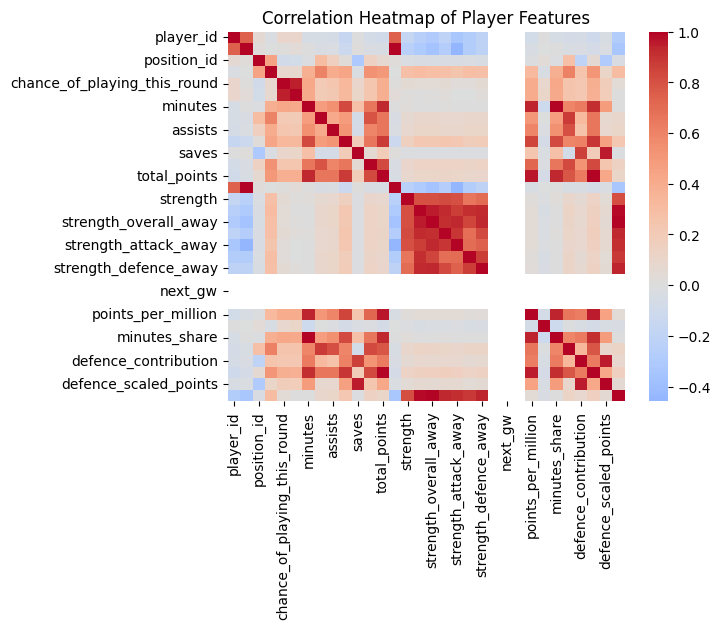

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols =  players_full.select_dtypes(include='number')
sns.heatmap(numeric_cols.corr(),cmap='coolwarm',center=0)
plt.title("Correlation Heatmap of Player Features");

corr = numeric_cols.corr()['total_points'].sort_values(ascending=False)  # This gives you a ranked list of features most correlated with total points.
print(corr.head(15))

From  the output list above, we see that about 9-10 features are the strongest predictors and the rest could be the weaker signals.

We can also check feature importance by running a quick Random Forest Regressor model so that it can show us the top features that matter from the 39 that we have.

In [180]:
from sklearn.ensemble import RandomForestRegressor

X = players_full.select_dtypes(include='number').fillna(0)
y = players_full['total_points']

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).head(15))


total_points             0.753875
attack_scaled_points     0.240850
points_per_million       0.002589
bonus                    0.000557
goals_scored             0.000428
attack_contribution      0.000413
price                    0.000339
defence_scaled_points    0.000278
position_id              0.000142
strength_defence_away    0.000136
defence_contribution     0.000134
minutes                  0.000077
strength_attack_home     0.000047
minutes_share            0.000035
form_per_90              0.000018
dtype: float64


The feature 'total_points' is our target so we cannot use it as a predictor. The model places 'attack_scaled_points' as moderately important with 0.24, while the rest of the features drop sharply because maybe the model did not find them predictive enough

In [181]:
# The shortlist of features
selected_feat = ['player_name',
                 'team_name',
                 'position_id',
                 'price',
                 'points_per_million',
                 'minutes_share',
                 'attack_scaled_points',
                 'bonus',
                 'attack_contribution',
                 'defence_contribution',
                 'chance_of_playing_this_round',
                 'chance_of_playing_next_round']

# new dataframe for our model
player_draft = players_full[selected_feat]
player_draft.head()

,player_name,team_name,position_id,price,points_per_million,minutes_share,attack_scaled_points,bonus,attack_contribution,defence_contribution,chance_of_playing_this_round,chance_of_playing_next_round
0,David Raya Martín,Arsenal,1,6.0,110.000000,1.000000,90420.0,3,0,36,100,100
1,Kepa Arrizabalaga Revuelta,Arsenal,1,4.1,0.000000,0.000000,0.0,0,0,0,100,100
2,Karl Hein,Arsenal,1,4.0,0.000000,0.000000,0.0,0,0,0,0,0
3,Tommy Setford,Arsenal,1,3.9,0.000000,0.000000,0.0,0,0,0,100,100
4,Gabriel dos Santos Magalhães,Arsenal,2,6.2,130.645161,0.733333,110970.0,13,3,20,0,0


# Optimization

In [182]:
from pulp import LpProblem,LpMaximize,LpVariable,lpSum,LpStatus, PULP_CBC_CMD

# load dataset
data = player_draft.copy()

# Build Expected points proxy for the next GameWeek
def safe_div(a,b):
  return a / b if b != 0 else 0

avail = np.maximum(
    data['chance_of_playing_this_round'].fillna(0) / 100,
    data['chance_of_playing_next_round'].fillna(0) / 100
)

base = (
    0.40 * data['points_per_million'].fillna(0) +
    0.20 * data['minutes_share'].fillna(0) +
    0.25 * data['attack_contribution'].fillna(0) +
    0.15 * data['defence_contribution'].fillna(0)
)

ctx = 0.10 * (data['attack_scaled_points'].fillna(0) / ( 1 + data['attack_scaled_points'].fillna(0)))

data['expected_points_next_gw'] = avail * (base + ctx)

# Keep players with >=30% chance by filtering very low availability
data = data[avail >= 0.3].copy()

# Ensuring no NaN values and clean index
data[['price','expected_points_next_gw']] = data[['price','expected_points_next_gw']]
data.reset_index(drop=True, inplace=True)

# init model
model = LpProblem("FPL_Best_XI_Next_GW", LpMaximize)

# Decision variable
x = {i: LpVariable(f"x_{i}", lowBound=0, upBound=1, cat="Binary") for i in data.index}
c = {i: LpVariable(f"c_{i}", lowBound=0, upBound=1, cat="Binary") for i in data.index}

# Objective function
model += lpSum((data.loc[i, 'expected_points_next_gw'] * x[i])+ (data.loc[i, 'expected_points_next_gw'] * c[i]) for i in data.index)

# Constraints
# Squad size (11)
model += lpSum(x[i] for i in data.index) == 11

# Formation minima(GK >= 1, DEF >=3, MID >= 3, FWD >= 1)
pos_req_min = {1: 1, 2: 3, 3: 3, 4: 1}
for pos_id, req in pos_req_min.items():
  model += lpSum(x[i] for i in data.index if data.loc[i, 'position_id'] == pos_id) >= req

# Budget
model += lpSum(data.loc[i, 'price'] * x[i] for i in data.index) <= 100

# Max 3 per team
for t in data['team_name'].unique():
  model += lpSum(x[i] for i in data.index if data.loc[i, 'team_name'] == t) <= 3

# Captain, exactly 1 and muust be selected!
model += lpSum(c[i] for i in data.index) == 1
for i in data.index:
  model += c[i] <= x[i]


#Solve
status = model.solve(PULP_CBC_CMD(msg=False))
print("Status:", LpStatus[status])

# Results
chosen = [i for i in data.index if x[i].value() == 1]
captain_idx = [i for i in data.index if c[i].value() == 1][0]

squad = data.loc[chosen].copy()
total_cost = squad['price'].sum() / 10
objective_val = sum(data.loc[i, 'expected_points_next_gw'] * x[i].value() + c[i].value() for i in data.index)

# Printing!!
print(f"Selected XI: {len(squad)} | Total cost: {total_cost:.1f}M | Objective: {objective_val:.3f}")
print("Captain:", data.loc[captain_idx, 'player_name'])

cols = ['player_name','team_name','position_id','price','expected_points_next_gw',
        'points_per_million','minutes_share','attack_contribution','defence_contribution']
print(squad[cols].sort_values(['position_id','team_name','player_name']).to_string(index=False))


Status: Optimal
Selected XI: 11 | Total cost: 5.6M | Objective: 686.944
Captain: Marc Guéhi
                     player_name      team_name  position_id  price  expected_points_next_gw  points_per_million  minutes_share  attack_contribution  defence_contribution
                     Robin Roefs     Sunderland            1    4.7                64.218084          136.170213       1.000000                    0                    63
                      Matty Cash    Aston Villa            2    4.8                63.779184          152.083333       0.979259                    4                    11
                 Trevoh Chalobah        Chelsea            2    5.3                65.114569          154.716981       0.888889                    4                    13
                  Chris Richards Crystal Palace            2    4.6                64.107509          156.521739       0.994074                    0                     8
                      Marc Guéhi Crystal Palace      